
# ISIC 2024 - Skin Cancer Detection with 3D-TBP

Nicholas Kurtansky, Veronica Rotemberg, Maura Gillis, Kivanc Kose, Walter Reade, Ashley Chow. (2024). ISIC 2024 - Skin Cancer Detection with 3D-TBP. Kaggle. 

https://kaggle.com/competitions/isic-2024-challenge

Currently heavily in development.

In [1]:
import os
import os.path as path
import gc
import cv2
import math
import copy
import time
import random
import glob
import warnings

import h5py

from matplotlib import pyplot as plt
import seaborn as sns

from functools import partial

import numpy as np
import pandas as pd

# Pytorch
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torch.optim import lr_scheduler
# from torch.utils.data import Dataset, DataLoader
# from torch.cuda import amp
# import torchvision
# from torcheval.metrics.functional import binary_auroc

# Tensorflow 
import tensorflow as tf

# Sklearn 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 

# import timm

# Albumentations
import albumentations as A
# from albumentations.pytorch import ToTensorV2

2024-10-18 01:30:38.322757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 01:30:38.340703: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 01:30:38.345781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 01:30:38.358875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 01:30:39.106380: W tensorflow/compiler/tf2

In [2]:
env_cfg = {
    "seed": 42,
    # "device": nn.device("cuda:0" if nn.cuda. else "cpu"),
    "device" : "GPU" if tf.config.list_physical_devices('GPU') else "CPU",
    "verbosity": '3',
}
CONFIG = {
    "seed": 42,
    "epochs": 50,
    "img_size": 384,
    "model_name": "",
    "checkpoint_path" : "/ISIC2024_SkinCancerDetection/saved_models",
    "train_batch_size": 32,
    
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
}

print(f"Using device: {env_cfg['device']}")

Using device: GPU


I0000 00:00:1729207840.118209   57579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729207840.161799   57579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729207840.163318   57579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = env_cfg["verbosity"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = env_cfg["verbosity"]

In [4]:
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

tf.debugging.set_log_device_placement(False)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
def set_seed(seed=42):

    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    tf.random.set_seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
  
    # When running on the CuDNN backend, two further options must be set
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    
set_seed()

In [7]:
# https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only#Training-Function

ROOT_DIR = path.normpath("./data/")
TRAIN_DIR = f'{ROOT_DIR}/train-image/image/'

train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))
print(TRAIN_DIR)
print("Number of train_images:", len(train_images))

data/train-image/image/
Number of train_images: 401059


In [8]:
train_images[:5]

['data/train-image/image/ISIC_0015670.jpg',
 'data/train-image/image/ISIC_0015845.jpg',
 'data/train-image/image/ISIC_0015864.jpg',
 'data/train-image/image/ISIC_0015902.jpg',
 'data/train-image/image/ISIC_0024200.jpg']

data/train-image/image//ISIC_0015864.jpg


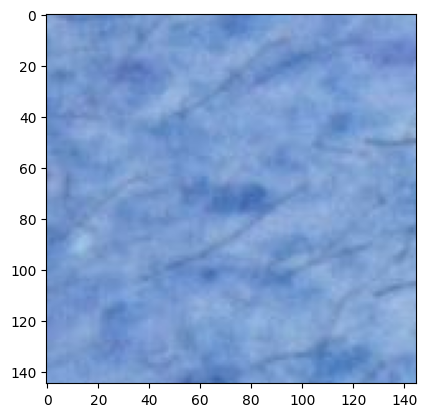

In [9]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

print(get_train_file_path("ISIC_0015864"))
img = cv2.imread(get_train_file_path("ISIC_0015864"))

plt.imshow(img)

In [10]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [11]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
isic_id,401059,401059,ISIC_0015670,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,401059.0,NaN,NaN,NaN,0.00098,0.031288,0.0,0.0,0.0,0.0,1.0
patient_id,401059,1042,IP_1117889,9184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_approx,398261.0,NaN,NaN,NaN,58.012986,13.596165,5.0,50.0,60.0,70.0,85.0
sex,389542,2,male,265546,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anatom_site_general,395303,5,posterior torso,121902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clin_size_long_diam_mm,401059.0,NaN,NaN,NaN,3.930827,1.743068,1.0,2.84,3.37,4.38,28.4
image_type,401059,1,TBP tile: close-up,401059,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_tile_type,401059,2,3D: XP,285903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tbp_lv_A,401059.0,NaN,NaN,NaN,19.974007,3.999489,-2.487115,17.330821,19.80191,22.304628,48.18961


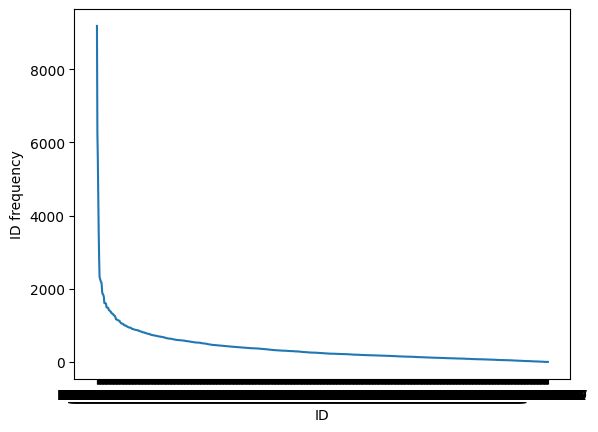

In [12]:
id_values = df["patient_id"].value_counts()

plt.plot(id_values)
plt.xlabel("ID")
plt.ylabel("ID frequency")
plt.show()


In [13]:
df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

print("Unique patients:",  df["patient_id"].unique().shape[0])
print()

print("Positive patient images:", df_positive.shape[0])
print("Unique positive patients:",  df_positive["patient_id"].unique().shape[0])
print()

print("Negative patient images:", df_negative.shape[0])
print("Unique negative patients:",  df_negative["patient_id"].unique().shape[0])

Unique patients: 1042

Positive patient images: 393
Unique positive patients: 259

Negative patient images: 400666
Unique negative patients: 1041


In [14]:
# Imbalanced dataset fix

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
print("Reduced dataset shape:", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)

# df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)

df.head()

Reduced dataset shape: (8253, 55) 393 (950,)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,data/train-image/image//ISIC_0082829.jpg
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,data/train-image/image//ISIC_0096034.jpg
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,data/train-image/image//ISIC_0104229.jpg
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,data/train-image/image//ISIC_0119495.jpg
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,data/train-image/image//ISIC_0157834.jpg


In [15]:
#

print("Number of unique patients: ", df["patient_id"].nunique())

Number of unique patients:  950


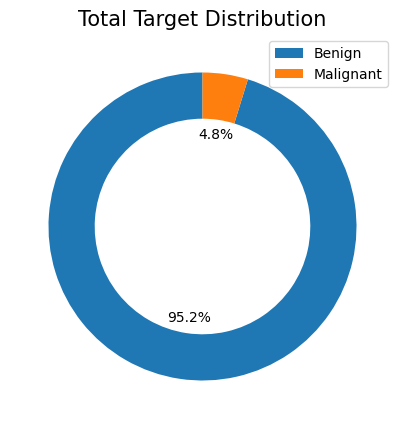

In [16]:
name = ['Benign', 'Malignant']

plt.figure(figsize = (5, 5))
plt.pie(df.target.value_counts(normalize = True), autopct = '%1.1f%%', startangle = 90, wedgeprops = dict(width = 0.3), 
        labeldistance = 1.2, radius = 1)
plt.title(f'Total Target Distribution', color = 'black', fontsize = 15)
plt.legend(name,)

plt.show()

In [17]:
missing_values_count = df.isnull().sum()
print(sorted(missing_values_count, reverse=True))

[8253, 8200, 8190, 8004, 7845, 7845, 7408, 234, 91, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        # ToTensorV2()
    ], p=1.)
}


In [19]:
def aug_fn(image, img_size, train):
    data = {"image":image}
    aug_data = data_transforms(**data["train" if train else "valid"])
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return tf.image.resize(aug_img, size=[img_size, img_size])

In [20]:
def process_data(image, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img

In [21]:
# Loading images, too slow
# x_train = []
# y_train = []
# with h5py.File('ISIC2024_SkinCancerDetection/data/train-image.hdf5', 'r') as f:
#        keys = list(f.keys())
#        for key in keys:
#            data = f[key]
#            x_train.append(data[()].decode('latin-1'))
#            
#            # x_train.append(f[key][:]) 
#            y_train.append(key)
#               
# print(len(x_train), len(y_train))
# print(x_train[:5], y_train[:5])

In [22]:
training_validation_hdf5 = h5py.File(f"{ROOT_DIR}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{ROOT_DIR}/test-image.hdf5", 'r')

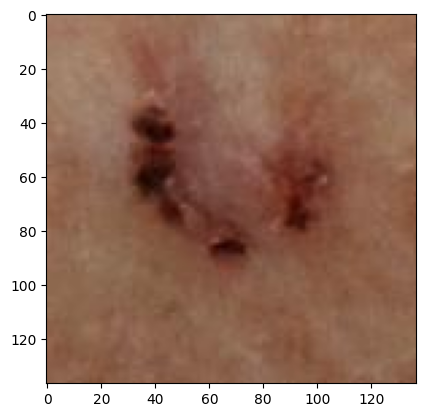

In [23]:
isic_id = df.isic_id.iloc[0]

byte_string = training_validation_hdf5[isic_id][()]
# print(f"Byte String: {byte_string[:20]}....")

nparr = np.frombuffer(byte_string, np.uint8)

image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
#print(f"Image: {image}")
plt.imshow(image);

In [24]:
data_ids = df.isic_id.values

images = [None]*len(data_ids)
for i, isic_id in enumerate(data_ids):
    images[i] = training_validation_hdf5[isic_id][()]

print(f"Loaded {len(images)} images.")
print(f"First image shape: {cv2.imdecode(np.frombuffer(images[0], np.uint8), cv2.IMREAD_COLOR).shape}.")

Loaded 8253 images.
First image shape: (137, 137, 3).


In [25]:
# hist = [cv2.calcHist([cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)], [0], None, [256], [0, 256]) for img in images]
# hist = np.array(hist).squeeze()
# plt.plot(hist[0], label="Blue")

In [26]:
# Based on https://www.kaggle.com/code/awsaf49/isic2024-kerascv-starter

def decoder(only_image=False, with_labels=True, target_size=(256, 256)):
    
    def decode_only_image(file_bytes, label):
        
        image = tf.io.decode_jpeg(file_bytes)
        
        image = tf.image.resize(image, size=target_size, method="area")
        
        image = tf.cast(image, tf.float32)
        image /= 255.0
  
        image = tf.reshape(image, [*target_size, 3])
        
        return image, label
    
    def decode_image(inp):
        
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        image = tf.image.resize(image, size=target_size, method="area")
        
        image = tf.cast(image, tf.float32)
        image /= 255.0
  
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp
    
    
    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label
    
  
    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, 1)
        return inp, label
    
    if only_image:
        return decode_only_image
    return decode_with_labels if with_labels else decode_image

multi_decoder = decoder(with_labels=False, target_size=(CONFIG["img_size"], CONFIG["img_size"]))
image_decoder = decoder(only_image=True, with_labels=False, target_size=(CONFIG["img_size"], CONFIG["img_size"]))

In [27]:
# Too slow
# decoded_images = [cv2.imdecode(np.frombuffer(img, np.uint8), cv2.IMREAD_COLOR)[...,::-1] for img in images]

In [28]:
# Multimodal dataset

# inp = {
#     "images": images, 
# #     # "features": features
#        }

# # slices = (inp, df.target.values)

# # ds = tf.data.Dataset.from_tensor_slices(slices)
 
# ds = tf.data.Dataset.from_tensor_slices(images, df.target.values)
# ds = ds.cache()
# ds = ds.map(decoder, num_parallel_calls=AUTOTUNE)

# # ds = ds.shuffle(1024, seed=seed)
# # opt = tf.data.Options()
# # opt.deterministic = False
# # ds = ds.with_options(opt)

# ds = ds.batch(CONFIG['train_batch_size'], drop_remainder=True)

# # ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
# ds = ds.prefetch(AUTOTUNE)

In [29]:
# ds.cardinality()

In [30]:
# Too slow

# decoded_images = []
# target_size=(CONFIG["img_size"], CONFIG["img_size"])
# 
# for file_bytes in images:
#     with tf.device("/CPU:0"):
#         image = tf.io.decode_jpeg(file_bytes)
# 
#         image = tf.image.resize(image, size=target_size, method="area")
# 
#         image = tf.cast(image, tf.float32)
#         image /= 255.0
# 
#         image = tf.reshape(image, [*target_size, 3])
# 
#         decoded_images.append(image)
# 
# decoded_images = tf.stack(decoded_images)
# 
# decoded_images_np = decoded_images.numpy()
# 
# 
# print(decoded_images_np.shape)

In [31]:
print(df.target.values)

[1 1 1 ... 0 0 0]


In [32]:
# Hyperparameters
activation_func = 'gelu'
# activation_func = 'relu'
# activation_func = 'mish'
batch_size = 16
num_epochs = 5
learning_rate = 7e-3
criterion = tf.keras.losses.MeanSquaredError()
# criterion = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-5)

I0000 00:00:1729207849.229877   57579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729207849.231516   57579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729207849.232812   57579 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729207849.383545   57579 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [33]:
len(images)

8253

In [34]:
# Single image dataset

ds = tf.data.Dataset.from_tensor_slices((images, df.target.values))

ds = ds.cache()

ds = ds.map(image_decoder, num_parallel_calls=AUTOTUNE)

ds = ds.batch(batch_size=batch_size, drop_remainder=True)

# ds = ds.map(augment_fn, num_parallel_calls=AUTOTUNE)

ds = ds.prefetch(batch_size)

ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=515>

In [35]:
tf.data.experimental.AUTOTUNE

-1

In [36]:
for batch in ds.take(1):
    images, labels = batch
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (16, 384, 384, 3)
Labels shape: (16,)


2024-10-18 01:30:49.918820: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-18 01:30:49.919978: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
ds_size = ds.cardinality().numpy()

ds.shuffle(buffer_size=len(ds))

train_size = int(0.8 * ds_size)

train_ds = ds.take(train_size)
valid_ds = ds.skip(train_size)

print(len(train_ds), len(valid_ds))

412 103


In [38]:
train_c = 0
val_c = 0

for batch in train_ds:
    train_c += sum(batch[1])

for batch in valid_ds:
    val_c += sum(batch[1])

print(train_c, val_c)

2024-10-18 01:30:54.211637: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-18 01:30:54.216003: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


tf.Tensor(393, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)


In [39]:
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        
        #self.flatten_layer = keras.layers.Flatten(name="flatten")

        self.conv1 = tf.keras.layers.Conv2D(filters=4, kernel_size=(4, 4), 
                                            input_shape=(batch_size, 384, 384, 3),
                                            activation=activation_func
                                            )
        
        self.pool1 = (tf.keras.layers.AveragePooling2D(pool_size=(4, 4)))

        self.conv2 = tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 4), 
                                            activation=activation_func
                                            )
        
        self.pool2 = (tf.keras.layers.AveragePooling2D(pool_size=(4, 4))) 

        # self.feature_extractor = []
        # for i in range(5):
        #     self.hidden_layers.append(tf.keras.layers.Dense(2048, activation=activation_func))
        #     self.hidden_layers.append(tf.keras.layers.Dropout(0.2))


        self.hidden_layers = []
        for i in range(1):
            self.hidden_layers.append(tf.keras.layers.Dense(256, activation=activation_func))
            self.hidden_layers.append(tf.keras.layers.Dropout(0.2))
            self.hidden_layers.append(tf.keras.layers.BatchNormalization())


        self.additional_layers = []
        for i in range(1):
            self.additional_layers.append(tf.keras.layers.Dense(128, activation=activation_func))
            self.additional_layers.append(tf.keras.layers.Dropout(0.2))

        self.output_layer = tf.keras.layers.Dense(1)


    def call(self, x):
        #x = self.flatten_layer(x)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        
        # for layer in self.feature_extractor:
        #     x = layer(x)

        for layer in self.hidden_layers:
            x = layer(x)

        # for layer in self.additional_layers:
            # x = layer(x)

        return self.output_layer(x)

model = Net()

In [40]:
model.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])

In [41]:
#next(iter(train_ds.take(1).as_numpy_iterator()))

In [42]:
model.fit(train_ds, epochs=num_epochs, validation_data=valid_ds)

Epoch 1/5


I0000 00:00:1729207857.816844   57655 service.cc:146] XLA service 0x7c9f440112a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729207857.816922   57655 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2024-10-18 01:30:57.884439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-18 01:30:58.007490: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  9/412 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4825 - loss: 0.4515 

I0000 00:00:1729207859.980883   57655 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


412/412 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9477 - loss: 0.0488 - val_accuracy: 1.0000 - val_loss: 5.7845e-06
Epoch 2/5
412/412 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9325 - loss: 0.0627 - val_accuracy: 1.0000 - val_loss: 3.1042e-06
Epoch 3/5
412/412 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9248 - loss: 0.0789 - val_accuracy: 1.0000 - val_loss: 4.3323e-06
Epoch 4/5
412/412 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9379 - loss: 0.0673 - val_accuracy: 1.0000 - val_loss: 8.9254e-07
Epoch 5/5
412/412 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9323 - loss: 0.0662 - val_accuracy: 1.0000 - val_loss: 2.3397e-07


In [43]:
model.summary()

Model: "net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (16, 381, 381, 4)      │           196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 92, 92, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ ?                      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 23, 23, 256)      │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (16, 23, 23, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (16, 23, 23, 1)        │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,881 (46.41 KB)

 Trainable params: 3,789 (14.80 KB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 7,580 (29.61 KB)

In [51]:
image_ids = []
predictions = []

with h5py.File("I/SIC2024_SkinCancerDetection/data/test-image.hdf5", 'r') as hdf:
    for key in hdf.keys():
        dataset = hdf[key]
        if isinstance(dataset, h5py.Dataset):
            
            img_data = dataset[()]
            img_data = np.frombuffer(img_data, dtype=np.uint8)
            img = Image.open(io.BytesIO(img_data))

            img = test_transform(img)

            img = img.unsqueeze(0).to(device) 

            output = model(img)
            # probability = output.squeeze().cpu().item()

            image_ids.append(key)
            predictions.append(output)

submission_df = pd.DataFrame({
    'isic_id': image_ids,
    'target': predictions 
})

submission_df.to_csv('submission.csv', index=False)

In [ ]:


train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

In [ ]:

# Set model to inference mode (not strictly necessary in TensorFlow as it handles this automatically)
# Making predictions on training and testing data
x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)

y_train_pred = model(x_train_tensor, training=False).numpy()
y_test_pred = model(x_test_tensor, training=False).numpy()

In [ ]:

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f'Train R-squared: {train_r2 * 100:.2f}%')
print(f'Test R-squared: {test_r2 * 100:.2f}%')
print(f'Test Mean Squared Error (MSE): {test_mse:.2f}')
print(f'Test Root Mean Squared Error (RMSE): {test_rmse:.2f}')
print(f'Test Mean Absolute Error (MAE): {test_mae:.2f}')

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', marker='o', linestyle='None')
plt.plot(y_test_pred, label='Predicted', marker='x', linestyle='None')
plt.legend()
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

print(model.summary())
print(model.get_config())
print(optimizer.get_config())
print(model.loss)

In [ ]:
# Transfer Learning [freeze all layers of feature extractor]: Functional API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(CONFIG["img_size"], CONFIG["img_size"], 3), weights="imagenet")
base_model.trainable = False

class MyModel(keras.Model):
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base = base_model
        self.layer_1 = keras.layers.Flatten()
        self.layer_2 = keras.layers.Dense(64, activation='relu')
        self.layer_3 = keras.layers.Dense(1, activation='softmax')

    @tf.function
    def call(self, xb):
        x = self.base(xb)
        x = self.layer_1(x)
        x = self.layer_2(x)
        return self.layer_3(x)


model = MyModel(base_model=base_model)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(train_data, epochs=2)